In [ ]:
import numpy as np
import pandas as pd
import gc
import os
import random

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pandas.plotting import scatter_matrix

In [ ]:
# Import the merged dataset created at the end of G25_01_Descriptive_Analysis_Cleansing_Preprocessing.ipynb
df_train_merge = pd.read_csv("merged_data.zip")

In [ ]:
# Check all rows of data have been loaded for df_train_merge data set
expected_rows = 19835460

if len(df_train_merge) == expected_rows:
  print(f'All {expected_rows} rows of df_train_merge have been imported')
else:
  print(f'WARNING: Only {len(df_train_merge)} rows imported, expected {expected_rows}')

All 19835460 rows of df_train_merge have been imported


In [ ]:
#Code from https://www.kaggle.com/zeynepkurban/ashrae-2/notebook
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
df_train_merge = reduce_mem_usage(df_train_merge)

Memory usage after optimization is: 605.33 MB
Decreased by 73.3%


In [ ]:
X_train = df_train_merge

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19835460 entries, 0 to 19835459
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   building_id        int16  
 1   meter              int8   
 2   timestamp          object 
 3   meter_reading      float32
 4   site_id            int8   
 5   primary_use        int8   
 6   square_feet        int32  
 7   air_temperature    float16
 8   cloud_coverage     int8   
 9   dew_temperature    float16
 10  precip_depth_1_hr  int16  
 11  hour               int8   
 12  weekday            int8   
 13  day                int8   
 14  month              int8   
dtypes: float16(2), float32(1), int16(2), int32(1), int8(8), object(1)
memory usage: 605.3+ MB


In [ ]:
# Seperate categorical features
categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday", "day", "month", "meter_reading", "timestamp"]
# In here, I put meter_readings and timestamp in categorical_features. Of course they are not categoric, I just store them in there.
X_train_categorical = X_train[categorical_features]
X_train_categorical = reduce_mem_usage(X_train_categorical)

# Seperate numerical features
numerical_features = ["air_temperature", "cloud_coverage", "dew_temperature", 
                      "precip_depth_1_hr", "square_feet"]
X_train_numerical = X_train[numerical_features]

X_train_numerical = reduce_mem_usage(X_train_numerical)

minmaxscaler = MinMaxScaler()
powertransformer = PowerTransformer(method='yeo-johnson', standardize=True)

X_train_numerical = minmaxscaler.fit_transform(X_train_numerical)
X_train_numerical = powertransformer.fit_transform(X_train_numerical)
X_train_numerical = pd.DataFrame(X_train_numerical, columns= numerical_features)

Memory usage after optimization is: 397.25 MB
Decreased by 0.0%
Memory usage after optimization is: 208.08 MB
Decreased by 0.0%


In [ ]:
X_train_categorical = X_train_categorical.reset_index(drop= True)
X_train_numerical = X_train_numerical.reset_index(drop= True)

In [ ]:
X_train = X_train_categorical

X_train["air_temperature"] = X_train_numerical.air_temperature
X_train["cloud_coverage"] = X_train_numerical.cloud_coverage
X_train["dew_temperature"] = X_train_numerical.dew_temperature
X_train["precip_depth_1_hr"] = X_train_numerical.precip_depth_1_hr
X_train["square_feet"] = X_train_numerical.square_feet

In [ ]:
# we copy the X_train which is preprocessed and ready to split. This is important because we will use this dataset later.
dataset_saved = X_train

In [ ]:
df_train_merge_LGBM = X_train

In [ ]:
# There is a huge operation here, We simply split dataframe train and test with protecting same rate of month and building_id in both dataframes.
# Simplt we split data with using two feature in stratfiy. We didn't do this operation directly with using stratfy because I didnt give accuracy results to us.
# It dublicate and increase the number of rows. This is why we used it seperately.
df_1 = df_train_merge_LGBM[df_train_merge_LGBM.month == 1.0]
y1 = df_1.building_id
X1 = df_1.drop("building_id",1)
df_2 = df_train_merge_LGBM[df_train_merge_LGBM.month == 2.0]
y2 = df_2.building_id
X2 = df_2.drop("building_id",1)
df_3 = df_train_merge_LGBM[df_train_merge_LGBM.month == 3.0]
y3 = df_3.building_id
X3 = df_3.drop("building_id",1)
df_4 = df_train_merge_LGBM[df_train_merge_LGBM.month == 4.0]
y4 = df_4.building_id
X4 = df_4.drop("building_id",1)
df_5 = df_train_merge_LGBM[df_train_merge_LGBM.month == 5.0]
y5 = df_5.building_id
X5 = df_5.drop("building_id",1)
df_6 = df_train_merge_LGBM[df_train_merge_LGBM.month == 6.0]
y6 = df_6.building_id
X6 = df_6.drop("building_id",1)
df_7 = df_train_merge_LGBM[df_train_merge_LGBM.month == 7.0]
y7 = df_7.building_id
X7 = df_7.drop("building_id",1)
df_8 = df_train_merge_LGBM[df_train_merge_LGBM.month == 8.0]
y8 = df_8.building_id
X8 = df_8.drop("building_id",1)
df_9 = df_train_merge_LGBM[df_train_merge_LGBM.month == 9.0]
y9 = df_9.building_id
X9 = df_9.drop("building_id",1)
df_10 = df_train_merge_LGBM[df_train_merge_LGBM.month == 10.0]
y10 = df_10.building_id
X10 = df_10.drop("building_id",1)
df_11 = df_train_merge_LGBM[df_train_merge_LGBM.month == 11.0]
y11 = df_11.building_id
X11 = df_11.drop("building_id",1)
df_12 = df_train_merge_LGBM[df_train_merge_LGBM.month == 12.0]
y12 = df_12.building_id
X12 = df_12.drop("building_id",1)

In [ ]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42, stratify=y5)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2, random_state=42, stratify=y6)
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size=0.2, random_state=42, stratify=y7)
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, test_size=0.2, random_state=42, stratify=y8)
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size=0.2, random_state=42, stratify=y9)
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size=0.2, random_state=42, stratify=y10)
X11_train, X11_test, y11_train, y11_test = train_test_split(X11, y11, test_size=0.2, random_state=42, stratify=y11)
X12_train, X12_test, y12_train, y12_test = train_test_split(X12, y12, test_size=0.2, random_state=42, stratify=y12)

In [ ]:
X1_train = pd.concat([X1_train, y1_train], axis=1, join="inner")
X2_train = pd.concat([X2_train, y2_train], axis=1, join="inner")
X3_train = pd.concat([X3_train, y3_train], axis=1, join="inner")
X4_train = pd.concat([X4_train, y4_train], axis=1, join="inner")
X5_train = pd.concat([X5_train, y5_train], axis=1, join="inner")
X6_train = pd.concat([X6_train, y6_train], axis=1, join="inner")
X7_train = pd.concat([X7_train, y7_train], axis=1, join="inner")
X8_train = pd.concat([X8_train, y8_train], axis=1, join="inner")
X9_train = pd.concat([X9_train, y9_train], axis=1, join="inner")
X10_train = pd.concat([X10_train, y10_train], axis=1, join="inner")
X11_train = pd.concat([X11_train, y11_train], axis=1, join="inner")
X12_train = pd.concat([X12_train, y12_train], axis=1, join="inner")

X1_test = pd.concat([X1_test, y1_test], axis=1, join="inner")
X2_test = pd.concat([X2_test, y2_test], axis=1, join="inner")
X3_test = pd.concat([X3_test, y3_test], axis=1, join="inner")
X4_test = pd.concat([X4_test, y4_test], axis=1, join="inner")
X5_test = pd.concat([X5_test, y5_test], axis=1, join="inner")
X6_test = pd.concat([X6_test, y6_test], axis=1, join="inner")
X7_test = pd.concat([X7_test, y7_test], axis=1, join="inner")
X8_test = pd.concat([X8_test, y8_test], axis=1, join="inner")
X9_test = pd.concat([X9_test, y9_test], axis=1, join="inner")
X10_test = pd.concat([X10_test, y10_test], axis=1, join="inner")
X11_test = pd.concat([X11_test, y11_test], axis=1, join="inner")
X12_test = pd.concat([X12_test, y12_test], axis=1, join="inner")

In [ ]:
train_dataframes = [X1_train, X2_train, X3_train, X4_train, X5_train, X6_train, X7_train, X8_train, X9_train, X10_train, X11_train, X12_train]
test_dataframes = [X1_test, X2_test, X3_test, X4_test, X5_test, X6_test, X7_test, X8_test, X9_test, X10_test, X11_test, X12_test]

X_train = pd.concat(train_dataframes)
X_test = pd.concat(test_dataframes)

y_train = X_train.meter_reading
X_train = X_train.drop("meter_reading",1)

y_test = X_test.meter_reading
X_test = X_test.drop("meter_reading",1)

In [ ]:
df_train_merge_LGBM = reduce_mem_usage(df_train_merge_LGBM)
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

del df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12

del X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,X7_train,X8_train,X9_train,X10_train,X11_train,X12_train

del X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12

Memory usage after optimization is: 586.41 MB
Decreased by 49.2%
Memory usage after optimization is: 529.66 MB
Decreased by 46.2%
Memory usage after optimization is: 132.42 MB
Decreased by 46.2%


In [ ]:
# Log trasformation on "meter_Reading" features
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
# In here, we divide dataframe as validation and test.
# Set model parameters and also train the model
X_train = X_train.drop("timestamp", 1)
X_val = X_test[:int(X_test.shape[0] / 2)].drop("timestamp", 1)
test_timestamp = X_test[int(X_test.shape[0] / 2):].timestamp
X_test = X_test[int(X_test.shape[0] / 2):].drop("timestamp", 1)

y_train = y_train
y_val = y_test[:int(y_test.shape[0] / 2)]
y_test =  y_test[int(y_test.shape[0] / 2):]

categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday", "day", "month"]

X_train_lgbm = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
X_val_lgbm = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)

validation = [X_train_lgbm, X_val_lgbm]

paramameters = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_lgbm = lgb.train(paramameters, train_set=X_train_lgbm, num_boost_round=4000, valid_sets=validation, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.913604	valid_1's rmse: 0.903802
[400]	training's rmse: 0.847713	valid_1's rmse: 0.838802
[600]	training's rmse: 0.815773	valid_1's rmse: 0.810439
[800]	training's rmse: 0.78992	valid_1's rmse: 0.787455
[1000]	training's rmse: 0.762381	valid_1's rmse: 0.762382
[1200]	training's rmse: 0.741358	valid_1's rmse: 0.741019
[1400]	training's rmse: 0.724186	valid_1's rmse: 0.723372
[1600]	training's rmse: 0.710473	valid_1's rmse: 0.711177
[1800]	training's rmse: 0.69745	valid_1's rmse: 0.698683
[2000]	training's rmse: 0.686546	valid_1's rmse: 0.688769
[2200]	training's rmse: 0.677263	valid_1's rmse: 0.680436
[2400]	training's rmse: 0.6671	valid_1's rmse: 0.670712
[2600]	training's rmse: 0.659507	valid_1's rmse: 0.663212
[2800]	training's rmse: 0.652341	valid_1's rmse: 0.654945
[3000]	training's rmse: 0.645361	valid_1's rmse: 0.647961
[3200]	traini

In [ ]:
y_pred = model_lgbm.predict(X_test, num_iteration=model_lgbm.best_iteration)

In [ ]:
#r2 score
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.908946339358838

In [ ]:
# Mean Squared Error of test dataset which is completely new for our model
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.39682789000111635

In [ ]:
# Root Mean Squared Error of test dataset which is completely new for our model
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared = False)


0.6299427672424824

In [ ]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns.values
feature_importance["importance"] = model_lgbm.feature_importance()

Text(0.5, 1.0, 'Feature Importance')

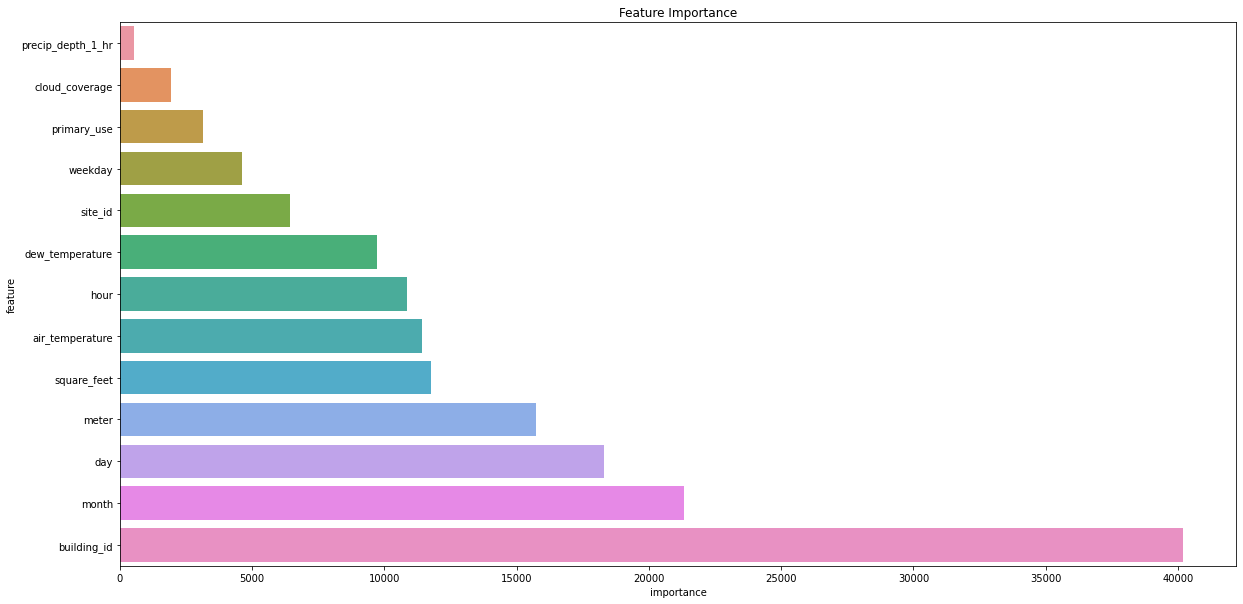

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance"))
plt.title("Feature Importance")

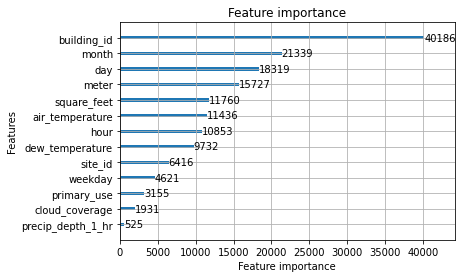

In [ ]:
lgb.plot_importance(model_lgbm)

In [ ]:
dataset = pd.DataFrame()
dataset["meter_reading_real"] = y_test
dataset["timestamp"] = test_timestamp
dataset["meter_reading_pred"] = y_pred
dataset = dataset.reset_index().drop("index",1)

In [ ]:
y_mean_time_real = dataset[["meter_reading_real", "timestamp"]]
y_mean_time_pred = dataset[["meter_reading_pred", "timestamp"]]

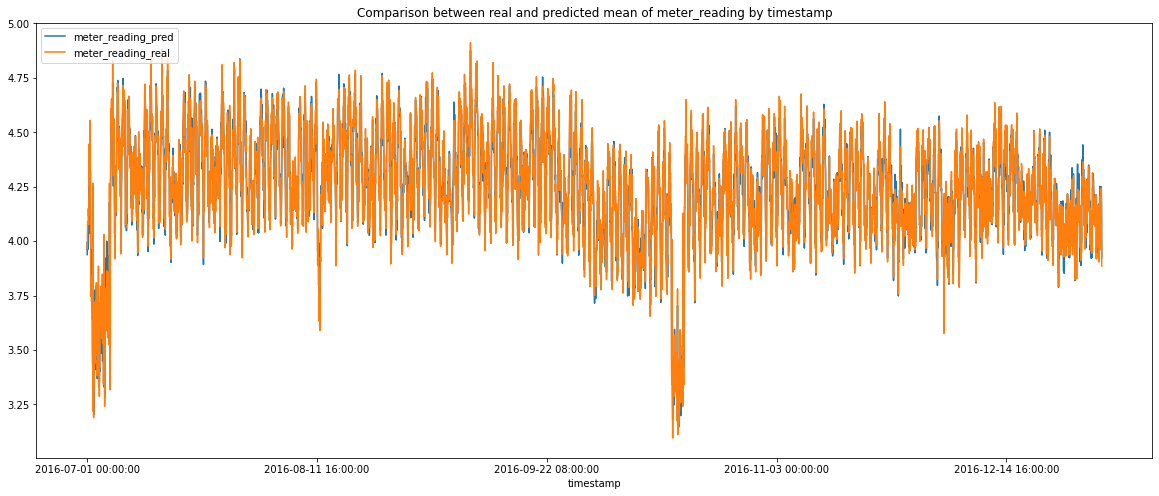

In [ ]:
# In this graph, we plot mean values of predicted and real values of meter_reading by time. We plot the mean values because there are lots of buildings (over than 1000).
# So using mean values is a best way to see the all prediction in a one graph.
y_mean_time_pred = y_mean_time_pred.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = y_mean_time_real.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted mean of meter_reading by timestamp")
plt.legend(loc="upper left")

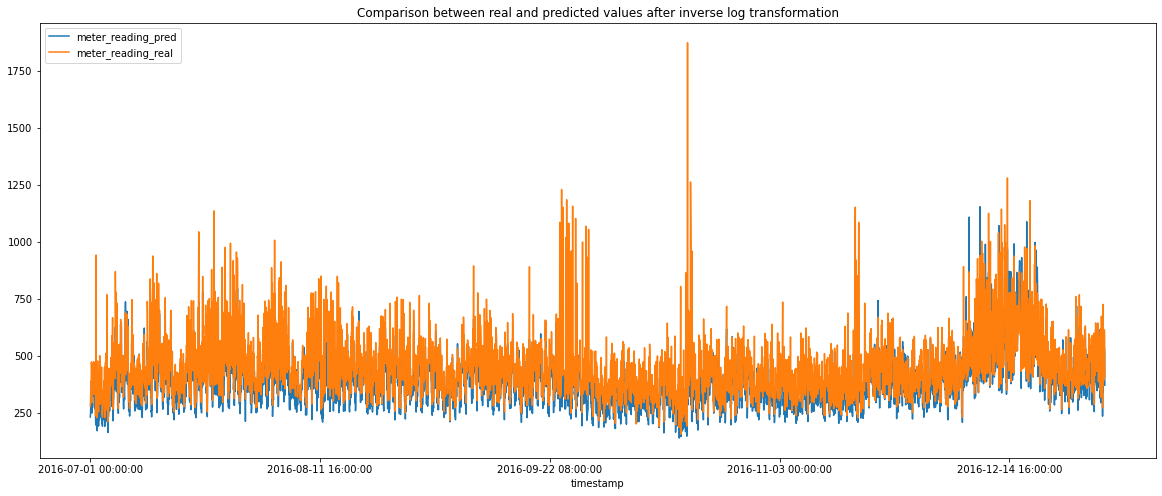

In [ ]:
# Plot without log transformation
dataset = pd.DataFrame()
dataset["meter_reading_real"] = np.expm1(y_test)
dataset["timestamp"] = test_timestamp
dataset["meter_reading_pred"] = np.expm1(y_pred)
dataset = dataset.reset_index().drop("index",1)

y_mean_time_real = dataset[["meter_reading_real", "timestamp"]]
y_mean_time_pred = dataset[["meter_reading_pred", "timestamp"]]

y_mean_time_pred = y_mean_time_pred.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = y_mean_time_real.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values after inverse log transformation")
plt.legend(loc="upper left")

In [ ]:
# Now, we will split the main dataset in a different approach. In the first model, we used train_test_split and preserved the rate of building_id and month in both dataset.
# But now, we split our dataset by timestamp. At first, we will order dataset by timestamp. 
# Then, first 80% of dataset will be train_dataset, next 10% will be validation_dataset and the remain %10 percent will be test dataset.
# Finally, we will compare the difference between models.

In [ ]:
dataset_saved = reduce_mem_usage(dataset_saved)
df_train = dataset_saved.sort_values("timestamp")

Memory usage after optimization is: 586.41 MB
Decreased by 0.0%


In [ ]:
#df_train = pd.get_dummies(df_train, columns=['site_id',"meter", "primary_use", "month"])
df_train.building_id = np.log(df_train.building_id)

In [ ]:
df_train.columns

Index(['building_id', 'site_id', 'meter', 'primary_use', 'hour', 'weekday',
       'day', 'month', 'meter_reading', 'timestamp', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'square_feet'],
      dtype='object')

In [ ]:
X_train = df_train[:int(df_train.shape[0]*8 / 10)].drop(["timestamp", "meter_reading"], 1)
X_val = df_train[int(df_train.shape[0]*8 / 10):int(df_train.shape[0]*9 / 10)].drop(["timestamp", "meter_reading"], 1)
X_test = df_train[int(df_train.shape[0]*9 / 10):].drop(["timestamp", "meter_reading"], 1)

test_timestamp = df_train[int(df_train.shape[0]*9 / 10):].timestamp

y_train = df_train[:int(df_train.shape[0]*8 / 10)].meter_reading
y_val = df_train[int(df_train.shape[0]*8 / 10):int(df_train.shape[0]*9 / 10)].meter_reading
y_test =  df_train[int(df_train.shape[0]*9 / 10):].meter_reading


y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday", "day", "month"]

X_train_lgbm = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
X_val_lgbm = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)

validation = [X_train_lgbm, X_val_lgbm]

paramameters = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_lgbm = lgb.train(paramameters, train_set=X_train_lgbm, num_boost_round=4000, valid_sets=validation, verbose_eval=200, early_stopping_rounds=200)




Building model with first half and validating on second half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 1.23752	valid_1's rmse: 1.28013
[400]	training's rmse: 1.11993	valid_1's rmse: 1.21845
[600]	training's rmse: 1.04139	valid_1's rmse: 1.20092
[800]	training's rmse: 0.978734	valid_1's rmse: 1.1819
[1000]	training's rmse: 0.933141	valid_1's rmse: 1.16927
[1200]	training's rmse: 0.901224	valid_1's rmse: 1.16445
[1400]	training's rmse: 0.875546	valid_1's rmse: 1.15915
[1600]	training's rmse: 0.853788	valid_1's rmse: 1.16067
Early stopping, best iteration is:
[1411]	training's rmse: 0.874394	valid_1's rmse: 1.1588


In [ ]:
y_pred = model_lgbm.predict(X_test, num_iteration=model_lgbm.best_iteration)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7018447463584689

In [ ]:
# Mean Squared Error of test dataset which is completely new for our model
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

1.339049927030213

In [ ]:
# Root Mean Squared Error of test dataset which is completely new for our model
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared = False)



1.1571732484940243

In [ ]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns.values
feature_importance["importance"] = model_lgbm.feature_importance()

Text(0.5, 1.0, 'Feature Importance')

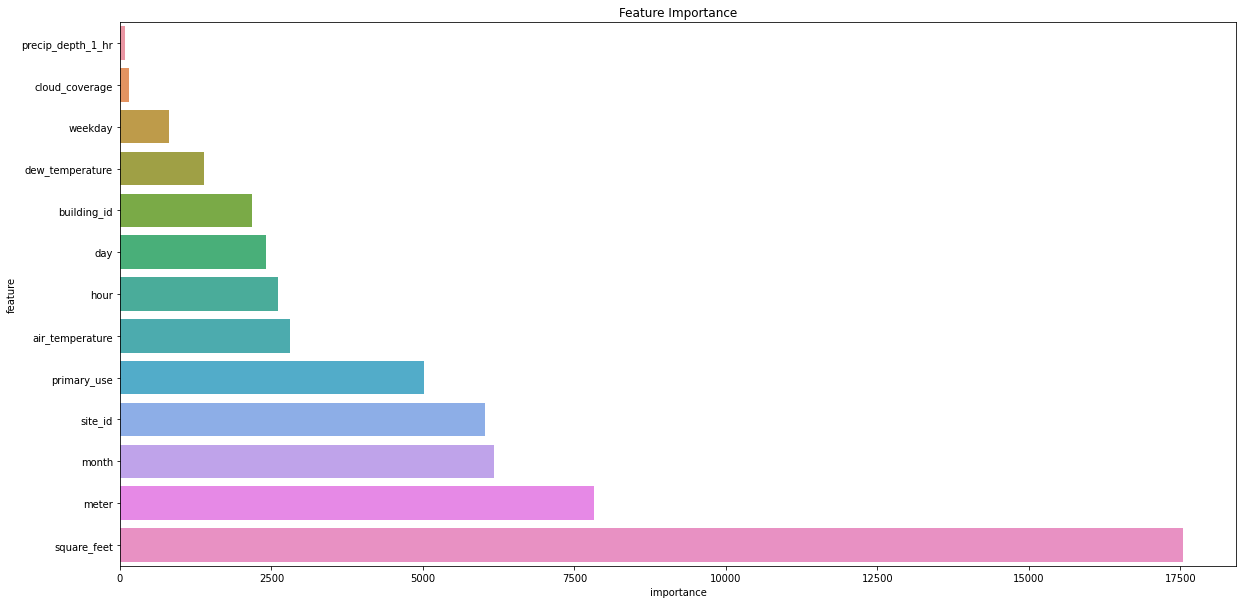

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance"))
plt.title("Feature Importance")

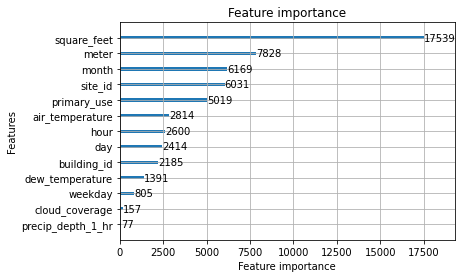

In [ ]:
lgb.plot_importance(model_lgbm)

In [ ]:
dataset = pd.DataFrame()
dataset["meter_reading_real"] = y_test
dataset["timestamp"] = test_timestamp
dataset["meter_reading_pred"] = y_pred
dataset = dataset.reset_index().drop("index",1)

In [ ]:
y_mean_time_real = dataset[["meter_reading_real", "timestamp"]]
y_mean_time_pred = dataset[["meter_reading_pred", "timestamp"]]

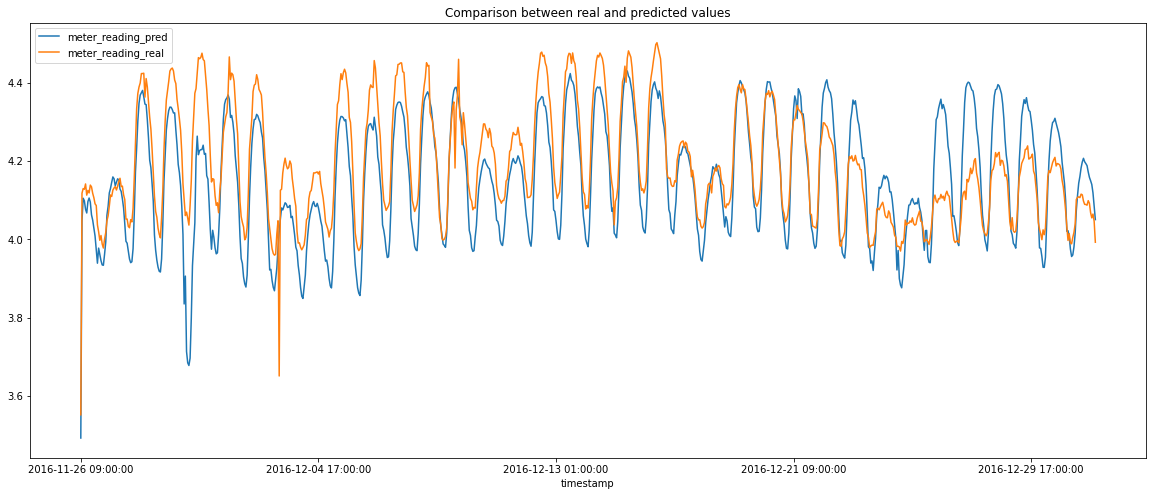

In [ ]:
y_mean_time_pred = y_mean_time_pred.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = y_mean_time_real.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8), )
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values")
plt.legend(loc="upper left")

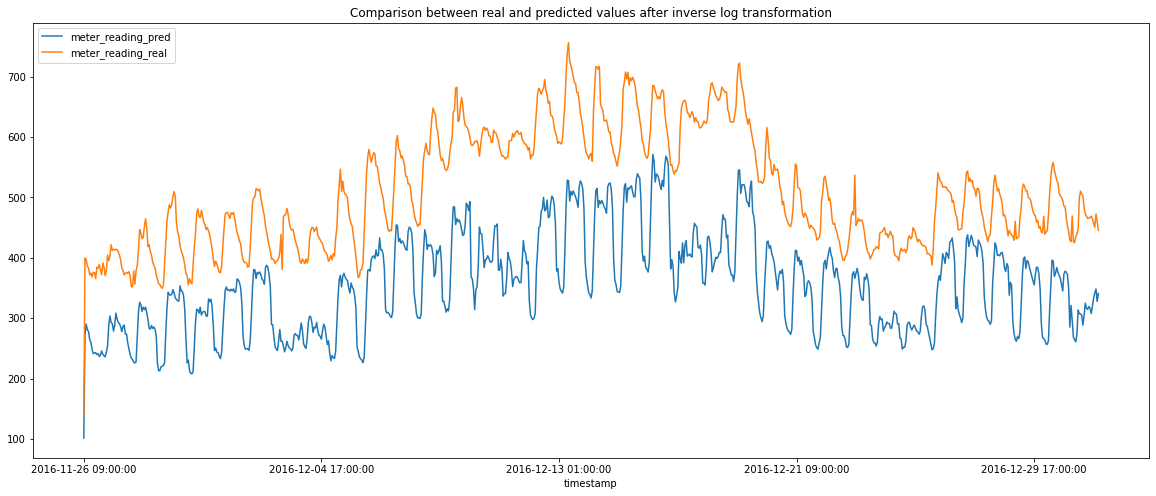

In [ ]:
dataset = pd.DataFrame()
dataset["meter_reading_real"] = np.expm1(y_test)
dataset["timestamp"] = test_timestamp
dataset["meter_reading_pred"] = np.expm1(y_pred)
dataset = dataset.reset_index().drop("index",1)

y_mean_time_real = dataset[["meter_reading_real", "timestamp"]]
y_mean_time_pred = dataset[["meter_reading_pred", "timestamp"]]

y_mean_time_pred = y_mean_time_pred.groupby('timestamp').meter_reading_pred.mean()
y_mean_time_real = y_mean_time_real.groupby('timestamp').meter_reading_real.mean()
y_mean_time_pred.plot(figsize=(20, 8))
y_mean_time_real.plot(figsize=(20, 8))
plt.title("Comparison between real and predicted values after inverse log transformation")
plt.legend(loc="upper left")